# Modelo Multilíngue de Sentimento para E-commerce

Este notebook constrói um modelo de classificação de sentimento capaz de processar reviews em português (Olist + B2W) e espanhol (Amazon Reviews).

Objetivo:

    Unificar datasets heterogêneos

    Treinar modelo multi-output: prevê sentimento + idioma

    Exportar modelo pronto para produção (joblib)

Fluxo: 📊 Carregamento → 🧹 Limpeza → 🎯 Modelagem → ✅ Deploy

## 1. Dependências e Setup

Aqui importamos as ferramentas essenciais:

    Datasets: KaggleHub, HuggingFace datasets

    ML: sklearn (TF-IDF + LogisticRegression multi-output)

    Visualização: matplotlib, seaborn

    Persistência: joblib (salva modelo treinado)


In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from datasets import load_dataset

import pandas as pd
import joblib

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, f1_score, recall_score)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\bruno\OneDrive\Área de Trabalho\hackathon-sentimentapi-analytics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Dados em Português: Olist + B2W

Olist (Kaggle): Reviews reais de e-commerce brasileiro
B2W (HuggingFace): Reviews da maior varejista brasileira

Desafio: Datasets com estruturas diferentes → padronizar para ['texto', 'sentimento']

In [2]:
file_path = 'olist_order_reviews_dataset.csv'

# Load the latest version

df_olist = kagglehub.dataset_load( KaggleDatasetAdapter.PANDAS,
 "olistbr/brazilian-ecommerce", file_path, pandas_kwargs={"encoding":'utf-8', "quotechar":'"', "on_bad_lines":'skip'})

hf = load_dataset("ruanchaves/b2w-reviews01")

df_b2w = pd.concat([hf['train'].to_pandas()], ignore_index=True)

ValueError: Error reading file: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.


In [ ]:
df_b2w.drop(axis="columns", columns=(['submission_date', 'reviewer_id', 'product_id', 'product_name',
 'product_brand', 'site_category_lv1', 'site_category_lv2',
 'review_title', 'reviewer_birth_year', 'reviewer_gender', 'reviewer_state', 'recommend_to_a_friend']), inplace=True)

In [ ]:
df_olist.drop(axis="columns", columns=(['review_id', 'order_id','review_creation_date',
 'review_answer_timestamp', 'review_comment_title']), inplace=True)

In [ ]:
df_b2w.dropna(subset=['review_text'], inplace=True)

df_olist.dropna(subset=['review_comment_message'], inplace=True)

In [ ]:
mapa_sentimentos = {

 1: 'Negativo',
 2: 'Negativo',
 3: 'Neutro',
 4: 'Positivo',
 5: 'Positivo'
}

df_b2w['sentimento'] = df_b2w['overall_rating'].map(mapa_sentimentos)

df_olist['sentimento'] = df_olist['review_score'].map(mapa_sentimentos)

df_olist.drop(axis="columns", columns=(['review_score']), inplace=True)

df_b2w.drop(axis="columns", columns=(['overall_rating']), inplace=True)

In [ ]:
df_olist.columns = ['texto', 'sentimento']

df_b2w.columns = ['texto', 'sentimento']

✅ Dados PT preparados!

Agora temos dois dataframes uniformes:

In [ ]:
print(df_b2w.shape)
print(df_olist.shape)

Próximo passo: Unificar e visualizar distribuição de sentimentos

In [ ]:
# Agora, concatenamos os dois datasets, ao mesmo tempo em que resetamos os index e os "embaralhamos"

# 1. Concatenar os dois dataframes (empilhar um sobre o outro)
# ignore_index=True ajuda a não duplicar índices antigos, mas o reset abaixo garante a limpeza final

df_pt = pd.concat([df_olist, df_b2w], ignore_index=True)

# 2. Embaralhar as linhas
# frac=1 significa "retorne 100% dos dados", mas em ordem aleatória
# reset_index(drop=True) recria o índice de 0 a N, para não ficar tudo bagunçado (ex: 5, 100, 2...)

df_pt = df_pt.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_pt.info()

## 3. Dataset Português Consolidado

170k+ reviews em português processados! 🎉

In [ ]:
df_pt.head()
df_pt['sentimento'].value_counts()

In [ ]:
# Proporção de sentimentos em português

df_pt['sentimento'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('Proporção de sentimentos - Português')
plt.ylabel('')
plt.show()

Observação: Dataset desbalanceado (mais Positivos), mas realista para e-commerce.

In [ ]:
# =============================================================================
# 🔄 OVERSAMPLING: Positivo FIXO, Neg/Neu aumentam até 40/20
# =============================================================================

print("📊 Original:")
counts_original = df_pt['sentimento'].value_counts()
print(counts_original)
print("\nPorcentagens:", (counts_original / len(df_pt)).round(3))

n_positivo_fixo = counts_original['Positivo']  # 105.846 FIxo!

# Calcular total necessário para Positivo = 40%
total_desejado = int(n_positivo_fixo / 0.40)  # ~265k linhas

target_counts = {
    'Positivo': n_positivo_fixo,      # Fixo: 105.846
    'Negativo': int(0.40 * total_desejado),  # ~106k
    'Neutro':   int(0.20 * total_desejado)   # ~53k
}

print(f"\n🎯 Dataset FINAL: {total_desejado:,} linhas")
print("Alvos oversampling:")
for k, v in target_counts.items():
    atual = counts_original.get(k, 0)
    print(f"  {k}: {v:,} (+{v - atual:+,})")

# Pipeline SMOTE só para Negativo e Neutro

pipeline_oversample = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, lowercase=True, ngram_range=(1,2))),
    ('smote', SMOTE(
        sampling_strategy={
            'Negativo': target_counts['Negativo'],
            'Neutro': target_counts['Neutro']
        },
        random_state=42,
        k_neighbors=5
    ))
])

# Executar
X_resampled = pipeline_oversample.fit_resample(df_pt["texto"], df_pt["sentimento"])
X_vetores = X_resampled[0]
y_balanceado = X_resampled[1]

# Reconverter textos
tfidf_fitted = pipeline_oversample.named_steps['tfidf']
textos_oversampled = tfidf_fitted.inverse_transform(X_vetores)

df_pt_oversampled = pd.DataFrame({
    'texto': [' '.join(palavras) for palavras in textos_oversampled],
    'sentimento': y_balanceado
})

df_pt_oversampled = df_pt_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n✅ OVERSAMPLING CONCLUÍDO!")
print(df_pt_oversampled['sentimento'].value_counts(normalize=True).round(3))
print(f"📈 TOTAL: {len(df_pt_oversampled):,} linhas ✓")

# Gráfico comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
df_pt['sentimento'].value_counts(normalize=True).plot(kind='pie', ax=ax1, autopct='%1.1f%%')
ax1.set_title('Original (170k)')
df_pt_oversampled['sentimento'].value_counts(normalize=True).plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Oversampled 40/40/20 (265k)\nPositivo FIXO!')
plt.tight_layout()
plt.show()

In [ ]:
df_pt_oversampled.to_csv('../datasets/df_pt_oversampled.csv', encoding='utf-8',index=False, header=True, sep=';')

## 4. Dados em Espanhol: Amazon Reviews

Fonte: mteb/amazon_reviews_multi (es) do HuggingFace
Splits: train + test + validation → dataset único

Rótulos originais: 0,1=Negativo | 2=Neutro | 3,4=Positivo

In [ ]:
dataset = load_dataset("mteb/amazon_reviews_multi", "es")

df_es = pd.concat([dataset['train'].to_pandas(), dataset['test'].to_pandas(), dataset['validation'].to_pandas()], ignore_index=True)

In [ ]:
# DF_ES:

# 0,1 => Negativo - 2 => Neutro - 3,4 => Positivo. Criamos uma nova coluna com esse "Mapeamento" usando a função .map()

mapa_sentimentos = {
 0: 'Negativo',
 1: 'Negativo',
 2: 'Neutro',
 3: 'Positivo',
 4: 'Positivo'
}

df_es['sentimento'] = df_es['label'].map(mapa_sentimentos)

In [ ]:
df_es.drop(axis="columns", columns=['id', 'label', 'label_text'], inplace=True)

df_es.columns = ['texto', 'sentimento']

In [ ]:
# Proporção de sentimentos em espanhol

df_es['sentimento'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('Proporção de sentimentos - Espanhol')
plt.ylabel('')
plt.show()

## 5. Unificação em um Dataset Único

In [ ]:
df_pt_oversampled['idioma']="pt"
df_es['idioma']='es'

In [ ]:
# 1. Concatena
df_multi = pd.concat([df_pt_oversampled, df_es])

# 2. Embaralha e reseta o índice
# frac=1 -> Pega 100% das linhas aleatoriamente
# random_state=42 -> Garante que o embaralhamento seja sempre o mesmo (importante para reproduzir seus testes)
# reset_index(drop=True) -> Cria um índice novo (0, 1, 2...) e joga fora o antigo bagunçado

df_multi = df_multi.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_multi.to_csv('../datasets/df_multi_concatenado.csv', encoding='utf-8',index=False, header=True, sep=';')

## Dataset Multilíngue Final ✅

~470k+ reviews em PT+ES!

In [ ]:
# Proporção de sentimentos em multi

df_multi['sentimento'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', figsize=(4,4))
plt.title('Proporção de sentimentos - Multi')
plt.ylabel('')
plt.show()

In [ ]:
# Tamanho do dataset final

print('Total de linhas em df_multi:', len(df_multi))

# Distribuição de sentimentos por idioma

plt.figure(figsize=(6,4))

sns.countplot(data=df_multi, x='sentimento', hue='idioma')
plt.title('Sentimentos por idioma')
plt.xlabel('Sentimento')
plt.ylabel('Quantidade')
plt.tight_layout()
plt.show()

In [4]:
df_multi = pd.read_csv("../datasets/df_multi_concatenado.csv", sep=';')

df_multi = df_multi.sample(frac=1, random_state=42).reset_index(drop=True)

## 6. Treinamento Multi-Output

Arquitetura do modelo:

     X = df_multi['texto']                           # Input: textos raw

     y = df_multi[['sentimento', 'idioma']]          # Output: 2 targets

Pipeline:

     TF-IDF (10k features, ngrams 1-2, lowercase)

     MultiOutputClassifier(LogisticRegression)



Por que multi-output? Uma previsão → sentimento E idioma simultaneamente! 🚀

In [5]:
df_multi = df_multi.dropna()

In [6]:
df_multi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473721 entries, 0 to 474614
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   texto       473721 non-null  object
 1   sentimento  473721 non-null  object
 2   idioma      473721 non-null  object
dtypes: object(3)
memory usage: 14.5+ MB


In [7]:
# X: textos; y: DataFrame com duas colunas
print("⏳ Treinando modelo...")

X = df_multi['texto']
y = df_multi[['sentimento', 'idioma']]

base_clf = LogisticRegression(solver='lbfgs', max_iter=1000) #, class_weight='balanced'

modelo_multi = make_pipeline(TfidfVectorizer(max_features=10000, strip_accents='unicode',
 lowercase=True, ngram_range=(1, 2)), MultiOutputClassifier(base_clf))

modelo_multi.fit(X, y)



⏳ Treinando modelo...


Próximos passos:

    Testar em dados não vistos

    Métricas (F1-score por idioma)

    Deploy como API FastAPI


In [8]:
X = df_multi['texto']
y = df_multi[['sentimento', 'idioma']]

# Refazer split train/test (mesmo random_state para reproducibilidade)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Previsões no teste
print("Gerando previsões...")
y_pred = modelo_multi.predict(X_test)
y_pred_sent = y_pred[:, 0]  # Primeira coluna: sentimento
y_pred_idioma = y_pred[:, 1]  # Segunda coluna: idioma
y_true_sent = y_test['sentimento']
y_true_idioma = y_test['idioma']

# 3. Calcular métricas
def calcular_metricas(y_true, y_pred, nome):
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')

    print(f"\n=== Métricas {nome} ===")
    print(f"Acurácia: {acc:.4f}")
    print(f"F1 Macro: {f1_macro:.4f}")
    print(f"F1 Weighted: {f1_weighted:.4f}")
    print(f"Recall Macro: {recall_macro:.4f}")
    print(f"Recall Weighted: {recall_weighted:.4f}")

    return {
        'accuracy': acc, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted,
        'recall_macro': recall_macro, 'recall_weighted': recall_weighted
    }

metricas_sent = calcular_metricas(y_true_sent, y_pred_sent, "Sentimento")

metricas_idioma = calcular_metricas(y_true_idioma, y_pred_idioma, "Idioma")


Gerando previsões...

=== Métricas Sentimento ===
Acurácia: 0.8141
F1 Macro: 0.7605
F1 Weighted: 0.8043
Recall Macro: 0.7550
Recall Weighted: 0.8141

=== Métricas Idioma ===
Acurácia: 0.9995
F1 Macro: 0.9995
F1 Weighted: 0.9995
Recall Macro: 0.9995
Recall Weighted: 0.9995


In [9]:
#inclusao do objeto "model_metrics" como atributo do modelo_multi

modelo_multi.model_metrics = {
    "sentimento": {
        "acuracia": round(metricas_sent["accuracy"], 4),
        "f1_macro": round(metricas_sent["f1_macro"], 4),
        "f1_weighted": round(metricas_sent["f1_weighted"], 4),
        "recall_macro": round(metricas_sent["recall_macro"], 4),
        "recall_weighted": round(metricas_sent["recall_weighted"], 4),
    },
    "idioma": {
        "acuracia": round(metricas_idioma["accuracy"], 4),
        "f1_macro": round(metricas_idioma["f1_macro"], 4),
        "f1_weighted": round(metricas_idioma["f1_weighted"], 4),
        "recall_macro": round(metricas_idioma["recall_macro"], 4),
        "recall_weighted": round(metricas_idioma["recall_weighted"], 4),
    },
}

In [10]:
#dump do modelo
joblib.dump(modelo_multi, "../models/modelo_multi.joblib")

print("✅ Novo modelo MULTI salvo em: modelo_multi.joblib")

✅ Novo modelo MULTI salvo em: modelo_multi.joblib


🎯 Modelo Pronto para Produção!

✅ Sucesso! modelo_multi.joblib salvo em ../models/

## Relatório de Classificação

In [11]:
# Classification reports
print("\n=== Classification Report Sentimento ===")
print(classification_report(y_true_sent, y_pred_sent))
print("\n=== Classification Report Idioma ===")
print(classification_report(y_true_idioma, y_pred_idioma))


=== Classification Report Sentimento ===
              precision    recall  f1-score   support

    Negativo       0.82      0.90      0.86     37938
      Neutro       0.66      0.46      0.54     18938
    Positivo       0.85      0.91      0.88     37869

    accuracy                           0.81     94745
   macro avg       0.78      0.76      0.76     94745
weighted avg       0.80      0.81      0.80     94745


=== Classification Report Idioma ===
              precision    recall  f1-score   support

          es       1.00      1.00      1.00     42000
          pt       1.00      1.00      1.00     52745

    accuracy                           1.00     94745
   macro avg       1.00      1.00      1.00     94745
weighted avg       1.00      1.00      1.00     94745



## Visualizações

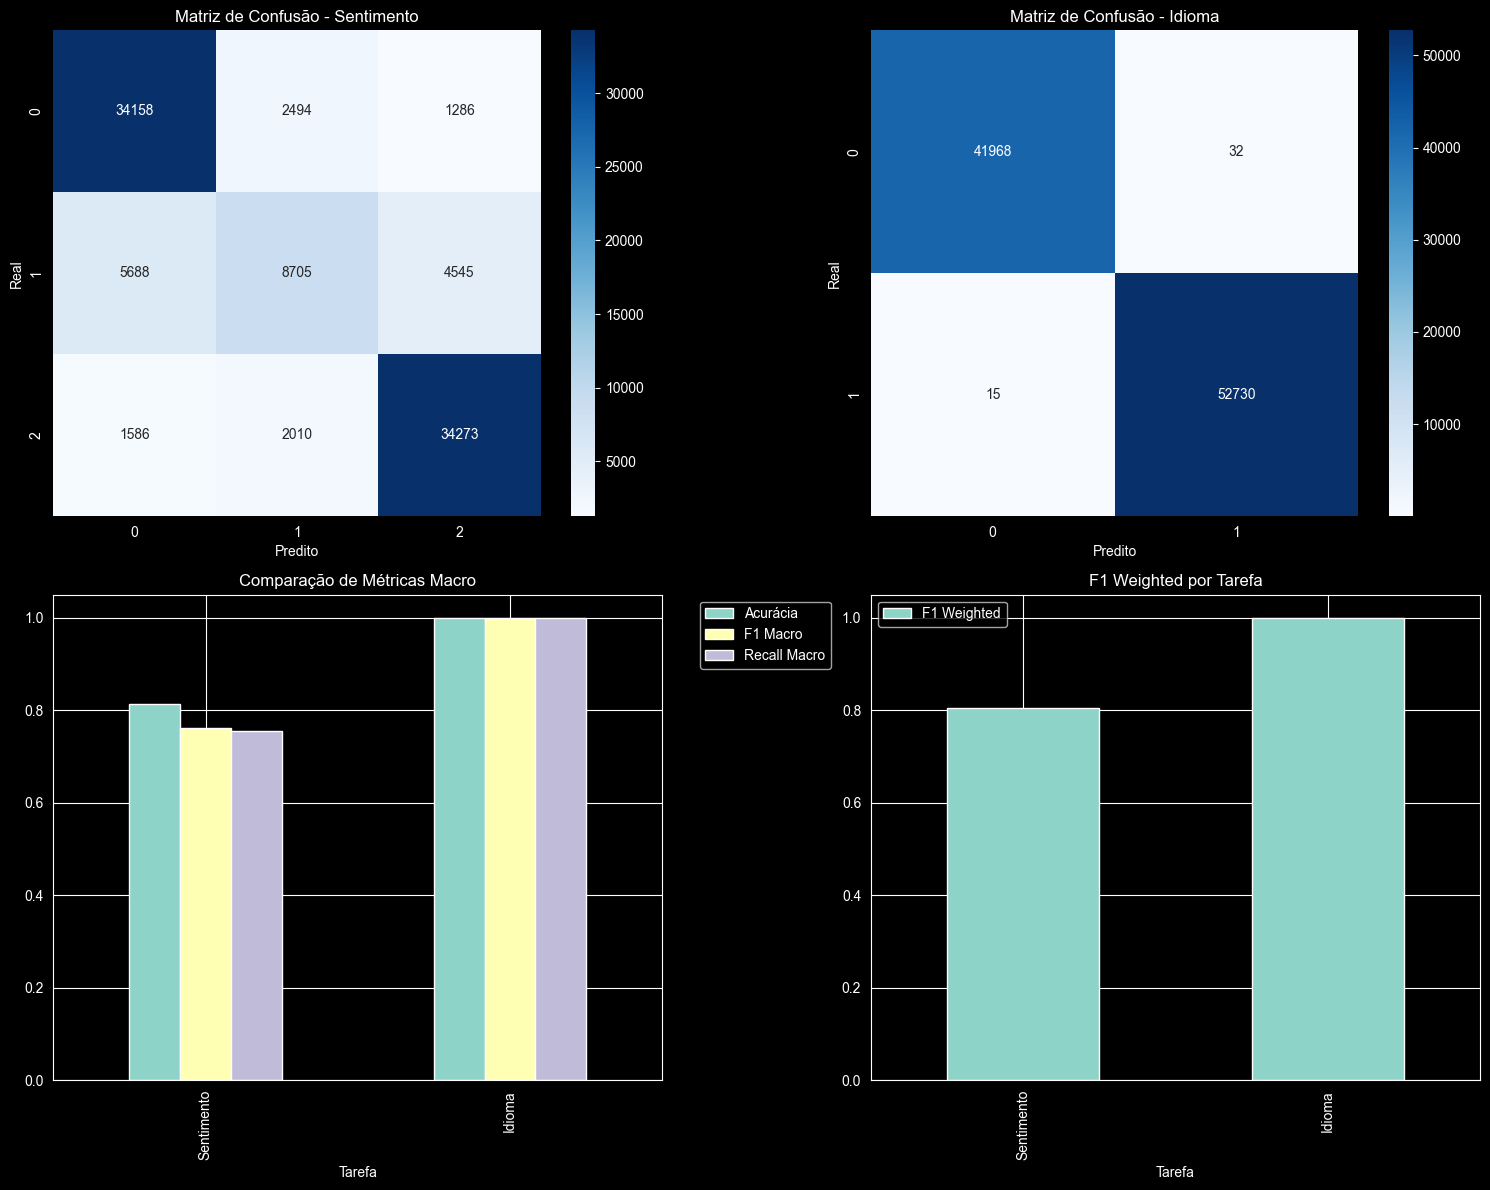


Avaliação concluída! Verifique as métricas e gráficos acima.


In [18]:
# Barras comparativas de métricas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Matriz de confusão Sentimento
cm_sent = confusion_matrix(y_true_sent, y_pred_sent)
sns.heatmap(cm_sent, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Matriz de Confusão - Sentimento')
axes[0,0].set_xlabel('Predito')
axes[0,0].set_ylabel('Real')

# Matriz de confusão Idioma
cm_idioma = confusion_matrix(y_true_idioma, y_pred_idioma)
sns.heatmap(cm_idioma, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Matriz de Confusão - Idioma')
axes[0,1].set_xlabel('Predito')
axes[0,1].set_ylabel('Real')

metricas = pd.DataFrame({
    'Tarefa': ['Sentimento', 'Idioma'],
    'Acurácia': [metricas_sent['accuracy'], metricas_idioma['accuracy']],
    'F1 Macro': [metricas_sent['f1_macro'], metricas_idioma['f1_macro']],
    'Recall Macro': [metricas_sent['recall_macro'], metricas_idioma['recall_macro']]
})
metricas.plot(x='Tarefa', kind='bar', ax=axes[1,0])
axes[1,0].set_title('Comparação de Métricas Macro')
axes[1,0].legend(bbox_to_anchor=(1.05, 1))

# F1 Weighted
f1_weighted = pd.DataFrame({
    'Tarefa': ['Sentimento', 'Idioma'],
    'F1 Weighted': [metricas_sent['f1_weighted'], metricas_idioma['f1_weighted']]
})
f1_weighted.plot(x='Tarefa', kind='bar', ax=axes[1,1])
axes[1,1].set_title('F1 Weighted por Tarefa')

plt.tight_layout()
plt.show()

print("\nAvaliação concluída! Verifique as métricas e gráficos acima.")